<a href="https://colab.research.google.com/github/chayan141/Langgraph-Projects/blob/main/Langgraph_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install -U langgraph langchain_openai langchain_core langchain_google_genai langgraph_sdk --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.4/70.4 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 441.4/441.4 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 16.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.8.5 requires google-ai-generativelanguage==0.6.15, but you have google-ai-generativelanguage

In [2]:
!pip install -U langchain-google-genai --quiet

In [3]:
from google.colab import userdata
gemini = userdata.get('gemini_api_key')
import os
os.environ['gemini_api_key'] = gemini

In [4]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_google_genai import ChatGoogleGenerativeAI

model = ChatGoogleGenerativeAI(model='gemini-2.0-flash',api_key=gemini)

# Human in the Loop

In [5]:
from typing import TypedDict
import uuid

from langgraph.checkpoint.memory import InMemorySaver
from langgraph.constants import START
from langgraph.graph import StateGraph
from langgraph.types import interrupt, Command

In [6]:
class State(TypedDict):
  some_text: str

In [7]:
def human_node(state: State):
  value = interrupt(
      {
          'text_to_revise':state['some_text']
      }
  )
  return{
      'some_text':value
  }

In [8]:
graph_builder = StateGraph(State)
graph_builder.add_node("human_node", human_node)
graph_builder.add_edge(START, "human_node")

In [9]:
checkpointer = InMemorySaver()
graph = graph_builder.compile(checkpointer=checkpointer)

config = {'configurable':{'thread_id':uuid.uuid4()}}
result = graph.invoke({'some_text':'original text'}, config=config)
print(result['__interrupt__'])

[Interrupt(value={'text_to_revise': 'original text'}, resumable=True, ns=['human_node:c42fd85c-350c-f054-06dd-36b2a1fea1df'])]


In [10]:
print(graph.invoke(Command(resume="Edited Text"),config = config))

{'some_text': 'Edited Text'}


In [16]:
graph.get_state(config)

StateSnapshot(values={'some_text': 'Edited Text'}, next=(), config={'configurable': {'thread_id': 'd5fdf99f-c501-4bef-98bb-86be2f24d71e', 'checkpoint_ns': '', 'checkpoint_id': '1f05ba76-a328-6529-8001-a18a4c00cd42'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}, 'thread_id': 'd5fdf99f-c501-4bef-98bb-86be2f24d71e'}, created_at='2025-07-08T02:58:24.784692+00:00', parent_config={'configurable': {'thread_id': 'd5fdf99f-c501-4bef-98bb-86be2f24d71e', 'checkpoint_ns': '', 'checkpoint_id': '1f05ba72-f9fa-6d0d-8000-760fa0b40886'}}, tasks=(), interrupts=())

# Tool Intervention

In [17]:
from typing import TypedDict
import uuid

from langgraph.constants import START, END
from langgraph.graph import StateGraph
from langgraph.types import interrupt, Command
from langgraph.checkpoint.memory import MemorySaver


In [18]:
# Define graph state
class State(TypedDict):
    age: int

In [19]:
# Node that asks for human input and validates it
def get_valid_age(state:State) -> State:

  prompt = "Please enter your age (must be a non negative integer)"

  while True:

    user_input = interrupt(prompt)

    try:

      age = int(user_input)
      if age < 0:
        raise ValueError("Age must be non-negative")
      break

    except ValueError:
      print(f"{user_input} Invalid input. Please try again.")

  return {'age':age}

In [20]:
# Node that uses the valid input
def report_age(state: State) -> State:
    print(f"✅ Human is {state['age']} years old.")
    return state

In [21]:
# Build the graph
builder = StateGraph(State)
builder.add_node("get_valid_age", get_valid_age)
builder.add_node("report_age", report_age)

builder.set_entry_point("get_valid_age")
builder.add_edge("get_valid_age", "report_age")
builder.add_edge("report_age", END)

# Create the graph with a memory checkpointer
checkpointer = MemorySaver()
graph = builder.compile(checkpointer=checkpointer)

In [22]:
# Run the graph until the first interrupt
config = {"configurable": {"thread_id": uuid.uuid4()}}
result = graph.invoke({}, config=config)
print(result["__interrupt__"])  # First prompt: "Please enter your age..."

[Interrupt(value='Please enter your age (must be a non negative integer)', resumable=True, ns=['get_valid_age:1f41c693-50ab-868b-8a8e-7d9d5cbaa86d'])]


In [23]:
# Simulate an invalid input (e.g., string instead of integer)
result = graph.invoke(Command(resume="not a number"), config=config)
print(result["__interrupt__"])  # Follow-up prompt with validation message

not a number Invalid input. Please try again.
[Interrupt(value='Please enter your age (must be a non negative integer)', resumable=True, ns=['get_valid_age:1f41c693-50ab-868b-8a8e-7d9d5cbaa86d'])]


In [24]:
# Simulate a second invalid input (e.g., negative number)
result = graph.invoke(Command(resume="-10"), config=config)
print(result["__interrupt__"])  # Another retry

not a number Invalid input. Please try again.
-10 Invalid input. Please try again.
[Interrupt(value='Please enter your age (must be a non negative integer)', resumable=True, ns=['get_valid_age:1f41c693-50ab-868b-8a8e-7d9d5cbaa86d'])]


In [25]:
# Provide valid input
final_result = graph.invoke(Command(resume="25"), config=config)
print(final_result)  # Should include the valid age

not a number Invalid input. Please try again.
-10 Invalid input. Please try again.
✅ Human is 25 years old.
{'age': 25}


Static Breakpoints : Setting breakpoints at compine tie or run time.

Dynamic Breakpoint: Inside a node using NodeInterrupt.

# Static Breakpoint

In [26]:
from IPython.display import Image, display
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph import StateGraph, START, END

In [27]:
class State(TypedDict):
    input: str


def step_1(state):
    print("---Step 1---")
    pass


def step_2(state):
    print("---Step 2---")
    pass


def step_3(state):
    print("---Step 3---")
    pass

In [28]:
builder = StateGraph(State)
builder.add_node("step_1", step_1)
builder.add_node("step_2", step_2)
builder.add_node("step_3", step_3)
builder.add_edge(START, "step_1")
builder.add_edge("step_1", "step_2")
builder.add_edge("step_2", "step_3")
builder.add_edge("step_3", END)

In [29]:
# Set up a checkpointer
checkpointer = InMemorySaver() # (1)!

graph = builder.compile(
    checkpointer=checkpointer, # (2)!
    interrupt_before=["step_3"] # (3)!
)

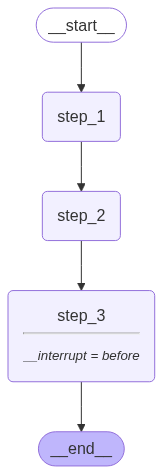

In [30]:
# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [31]:
# Input
initial_input = {"input": "hello world"}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    print(event)

{'input': 'hello world'}
---Step 1---
---Step 2---


In [32]:
# This will run until the breakpoint
# You can get the state of the graph at this point
print(graph.get_state(config))

StateSnapshot(values={}, next=(), config={'configurable': {'thread_id': 'f5c0df47-8f30-4f74-8fea-8eaec5e33cf4'}}, metadata=None, created_at=None, parent_config=None, tasks=(), interrupts=())


In [33]:
# You can continue the graph execution by passing in `None` for the input
for event in graph.stream(None, thread, stream_mode="values"):
    print(event)

{'input': 'hello world'}
---Step 3---


# Dynamic Breakpoint

In [37]:
from typing_extensions import TypedDict
from IPython.display import Image, display

from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.errors import NodeInterrupt


In [38]:
class State(TypedDict):
    input: str

In [39]:
def step_1(state: State) -> State:
    print("---Step 1---")
    return state

In [40]:
def step_2(state: State) -> State:
    # Let's optionally raise a NodeInterrupt
    # if the length of the input is longer than 5 characters
    if len(state["input"]) > 5:
        raise NodeInterrupt(
            f"Received input that is longer than 5 characters: {state['input']}"
        )
    print("---Step 2---")
    return state

In [41]:
def step_3(state: State) -> State:
    print("---Step 3---")
    return state

In [42]:
builder = StateGraph(State)
builder.add_node("step_1", step_1)
builder.add_node("step_2", step_2)
builder.add_node("step_3", step_3)
builder.add_edge(START, "step_1")
builder.add_edge("step_1", "step_2")
builder.add_edge("step_2", "step_3")
builder.add_edge("step_3", END)

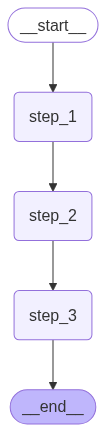

In [43]:
# Set up memory
memory = MemorySaver()

# Compile the graph with memory
graph = builder.compile(checkpointer=memory)

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [46]:
initial_input = {"input": "helloworld"}
thread_config = {"configurable": {"thread_id": "1"}}

for event in graph.stream(initial_input, thread_config, stream_mode="values"):
    print(event)

{'input': 'helloworld'}
---Step 1---
{'input': 'helloworld'}


In [47]:
state = graph.get_state(thread_config)
print(state.next)
print(state.tasks)

('step_2',)
(PregelTask(id='f74194aa-efd9-ace5-063f-44cb860c5f4a', name='step_2', path=('__pregel_pull', 'step_2'), error=None, interrupts=(Interrupt(value='Received input that is longer than 5 characters: helloworld', resumable=False, ns=None),), state=None, result=None),)


In [48]:
# NOTE: to resume the graph from a dynamic interrupt we use the same syntax as with regular interrupts -- we pass None as the input
for event in graph.stream(None, thread_config, stream_mode="values"):
    print(event)

{'input': 'helloworld'}


In [49]:
state = graph.get_state(thread_config)
print(state.next)
print(state.tasks)

('step_2',)
(PregelTask(id='f74194aa-efd9-ace5-063f-44cb860c5f4a', name='step_2', path=('__pregel_pull', 'step_2'), error=None, interrupts=(Interrupt(value='Received input that is longer than 5 characters: helloworld', resumable=False, ns=None),), state=None, result=None),)


# Using Breakpoints in Subgraph

In [50]:
from typing_extensions import TypedDict

from langgraph.graph import START, StateGraph
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.types import interrupt


class State(TypedDict):
    foo: str


def subgraph_node_1(state: State):
    return {"foo": state["foo"]}

In [51]:
subgraph_builder = StateGraph(State)
subgraph_builder.add_node(subgraph_node_1)
subgraph_builder.add_edge(START, "subgraph_node_1")
subgraph = subgraph_builder.compile(interrupt_before=["subgraph_node_1"])

In [52]:
builder = StateGraph(State)
builder.add_node("node_1", subgraph)  # directly include subgraph as a node
builder.add_edge(START, "node_1")

In [53]:
checkpointer = InMemorySaver()
graph = builder.compile(checkpointer=checkpointer)

In [54]:
config = {"configurable": {"thread_id": "1"}}

graph.invoke({"foo": ""}, config)

# Fetch state including subgraph state.
print(graph.get_state(config, subgraphs=True).tasks[0].state)

# resume the subgraph
graph.invoke(None, config)

StateSnapshot(values={'foo': ''}, next=('subgraph_node_1',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': 'node_1:b34455ab-1abb-ab5d-d480-690a96ddf960', 'checkpoint_id': '1f05bb02-2178-6943-8000-5b857294c56a', 'checkpoint_map': {'': '1f05bb02-216e-6a1f-8000-52bec94b95a9', 'node_1:b34455ab-1abb-ab5d-d480-690a96ddf960': '1f05bb02-2178-6943-8000-5b857294c56a'}}}, metadata={'source': 'loop', 'step': 0, 'parents': {'': '1f05bb02-216e-6a1f-8000-52bec94b95a9'}, 'thread_id': '1', 'langgraph_step': 1, 'langgraph_node': 'node_1', 'langgraph_checkpoint_ns': 'node_1:b34455ab-1abb-ab5d-d480-690a96ddf960'}, created_at='2025-07-08T04:00:49.282471+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': 'node_1:b34455ab-1abb-ab5d-d480-690a96ddf960', 'checkpoint_id': '1f05bb02-2171-6482-bfff-896a1dfe58ce', 'checkpoint_map': {'': '1f05bb02-216e-6a1f-8000-52bec94b95a9', 'node_1:b34455ab-1abb-ab5d-d480-690a96ddf960': '1f05bb02-2171-6482-bfff-896a1dfe58ce'}}}, tasks=(Pregel

{'foo': ''}

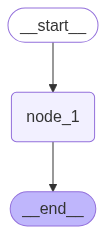

In [55]:
display(Image(graph.get_graph().draw_mermaid_png()))

# Time Travel


Used for - Understand Reasoning (Analyzing Every Steps), Debugging Mistakes: Identify where and why errors occurred, Explore Alternatives: Tests different paths to uncover better solutions.

In [56]:
import uuid

from typing_extensions import TypedDict, NotRequired
from langgraph.graph import StateGraph, START, END
from langchain.chat_models import init_chat_model
from langgraph.checkpoint.memory import InMemorySaver

In [57]:
class State(TypedDict):
    topic: NotRequired[str]
    joke: NotRequired[str]

In [58]:
def generate_topic(state: State):
    """LLM call to generate a topic for the joke"""
    msg = model.invoke("Give me a funny topic for a joke")
    return {"topic": msg.content}

In [59]:
def write_joke(state: State):
    """LLM call to write a joke based on the topic"""
    msg = model.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}

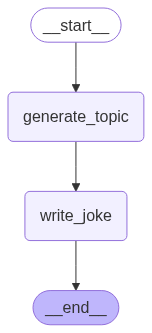

In [60]:
# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_topic", generate_topic)
workflow.add_node("write_joke", write_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_topic")
workflow.add_edge("generate_topic", "write_joke")
workflow.add_edge("write_joke", END)

# Compile
checkpointer = InMemorySaver()
graph = workflow.compile(checkpointer=checkpointer)
graph

In [61]:
config = {
    "configurable": {
        "thread_id": uuid.uuid4(),
    }
}
state = graph.invoke({}, config)

print(state["topic"])
print()
print(state["joke"])

Okay, here are a few funny joke topics, leaning into different comedic styles:

*   **Awkward Dates:** (Relatable cringe humor)
*   **Talking Animals:** (Silly, absurd)
*   **AI/Robots Trying to Be Human:** (Topical, slightly satirical)
*   **The Differences Between Men and Women (exaggerated):** (Classic, but tread carefully!)
*   **Food with Human-like Problems:** (Surreal, quirky)
*   **Things that Old People Say:** (Observational, nostalgic)
*   **The Struggles of Working From Home:** (Relatable, modern)
*   **Bad Puns:** (Self-explanatory!)
*   **Overly Enthusiastic Salespeople:** (Annoying but funny)
*   **The Absurdity of Everyday Life:** (Existential humor)

Pick the one that you think you can write the best joke about! Good luck!

I'll go with **AI/Robots Trying to Be Human** for a topical and slightly satirical joke.

Why did the robot get fired from the comedy club?

Because his jokes were too... *puts on sunglasses*... algorithm-ic. He just couldn't *compute* what was funny

In [62]:
# The states are returned in reverse chronological order.
states = list(graph.get_state_history(config))

for state in states:
    print(state.next)
    print(state.config["configurable"]["checkpoint_id"])
    print()

()
1f05bb12-3564-6f9f-8002-35728c76d4b2

('write_joke',)
1f05bb12-2a25-6afe-8001-beba222d33cf

('generate_topic',)
1f05bb12-1132-68d7-8000-4fdb2c774e55

('__start__',)
1f05bb12-112e-6ff6-bfff-666062cc2930



In [69]:
# This is the state before last (states are listed in chronological order)
selected_state = states[1]
print(selected_state.next)
print(selected_state.values)

('write_joke',)
{'topic': 'Okay, here are a few funny joke topics, leaning into different comedic styles:\n\n*   **Awkward Dates:** (Relatable cringe humor)\n*   **Talking Animals:** (Silly, absurd)\n*   **AI/Robots Trying to Be Human:** (Topical, slightly satirical)\n*   **The Differences Between Men and Women (exaggerated):** (Classic, but tread carefully!)\n*   **Food with Human-like Problems:** (Surreal, quirky)\n*   **Things that Old People Say:** (Observational, nostalgic)\n*   **The Struggles of Working From Home:** (Relatable, modern)\n*   **Bad Puns:** (Self-explanatory!)\n*   **Overly Enthusiastic Salespeople:** (Annoying but funny)\n*   **The Absurdity of Everyday Life:** (Existential humor)\n\nPick the one that you think you can write the best joke about! Good luck!'}


In [70]:
new_config = graph.update_state(selected_state.config, values={"topic": "chickens"})
print(new_config)

{'configurable': {'thread_id': 'a3f4a176-aef7-4d2f-8f43-f67305ea6097', 'checkpoint_ns': '', 'checkpoint_id': '1f05bb17-6891-693f-8002-3d3d5d411279'}}


In [71]:
graph.invoke(None, new_config)

{'topic': 'chickens',
 'joke': 'Why did the chicken cross the playground?\n\nTo get to the other slide!'}

# RAG Using Langgraph

In [73]:
!pip install -qU langchain-core

In [74]:
%pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.6 MB/s eta 0:00:00


In [75]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict

In [76]:
# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

In [77]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

In [78]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings

embeddings = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004", google_api_key=gemini)
vector = embeddings.embed_query("hello, world!")
vector[:5]

[0.006846265867352486,
 -0.02251487784087658,
 -0.05496913567185402,
 -0.020021894946694374,
 -0.010026923380792141]

In [79]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

In [80]:
# Index chunks
_ = vector_store.add_documents(documents=all_splits)

# Define prompt for question-answering
# N.B. for non-US LangSmith endpoints, you may need to specify
# api_url="https://api.smith.langchain.com" in hub.pull.
prompt = hub.pull("rlm/rag-prompt")

/usr/local/lib/python3.11/dist-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [81]:
# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

In [82]:
# Define application steps
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}

In [83]:
def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = model.invoke(messages)
    return {"answer": response.content}

In [84]:
# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate]) #adding Node
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

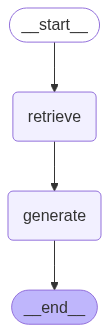

In [85]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [86]:
response = graph.invoke({"question": "What is Task Decomposition?"})
print(response["answer"])

Task decomposition is a method used to break down complex tasks into smaller, simpler steps. It can be achieved through prompting language models, using task-specific instructions, or with human input. Techniques like Chain of Thought (CoT) and Tree of Thoughts extend this by exploring multiple reasoning paths.


# Conversational RAG

In [87]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from typing_extensions import List, TypedDict

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

In [88]:
# Index chunks
_ = vector_store.add_documents(documents=all_splits)

We will have :

User input as a HumanMessage;

Vector store query as an AIMessage with tool calls;

Retrieved documents as a ToolMessage;

Final response as a AIMessage.

In [89]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

In [90]:
from langchain_core.tools import tool


@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

In [91]:
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode

In [92]:
# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = model.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}

In [94]:
# Step 2: Execute the retrieval.
tools = ToolNode([retrieve])

In [95]:
# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = model.invoke(prompt)
    return {"messages": [response]}

In [96]:
from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

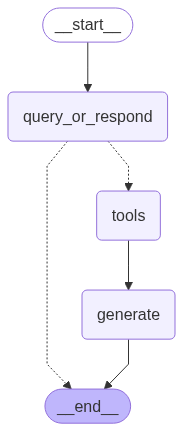

In [97]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [98]:
input_message = "Hello"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Hello
================================== Ai Message ==================================

Hello! How can I help you today?


In [99]:
input_message = "What is Task Decomposition?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is Task Decomposition?
================================== Ai Message ==================================
Tool Calls:
  retrieve (fc6a5ec5-1d0f-4acc-901c-4ec786bc5cd0)
 Call ID: fc6a5ec5-1d0f-4acc-901c-4ec786bc5cd0
  Args:
    query: Task Decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Component One: Planning#
A complicated task usually involves many steps. An agent needs to know what they are and plan ahead.
Task Decomposition#
Chain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and s

In [100]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

# Specify an ID for the thread
config = {"configurable": {"thread_id": "abc123"}}

In [101]:
input_message = "What is Task Decomposition?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is Task Decomposition?
================================== Ai Message ==================================
Tool Calls:
  retrieve (3bb8992b-8a8a-4b67-ae42-b216c483305c)
 Call ID: 3bb8992b-8a8a-4b67-ae42-b216c483305c
  Args:
    query: Task Decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Component One: Planning#
A complicated task usually involves many steps. An agent needs to know what they are and plan ahead.
Task Decomposition#
Chain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and s

In [102]:
input_message = "Can you look up some common ways of doing it?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Can you look up some common ways of doing it?
================================== Ai Message ==================================
Tool Calls:
  retrieve (4015d22d-3e0d-424a-a07a-7ab11df78ef7)
 Call ID: 4015d22d-3e0d-424a-a07a-7ab11df78ef7
  Args:
    query: common methods for task decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Component One: Planning#
A complicated task usually involves many steps. An agent needs to know what they are and plan ahead.
Task Decomposition#
Chain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks

# Creating Agent

In [104]:
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(model, [retrieve], checkpointer=memory)

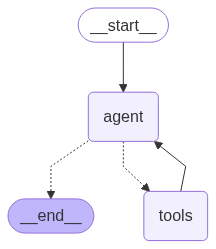

In [105]:
display(Image(agent_executor.get_graph().draw_mermaid_png()))

In [106]:
config = {"configurable": {"thread_id": "def234"}}

input_message = (
    "What is the standard method for Task Decomposition?\n\n"
    "Once you get the answer, look up common extensions of that method."
)

for event in agent_executor.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the standard method for Task Decomposition?

Once you get the answer, look up common extensions of that method.
================================== Ai Message ==================================
Tool Calls:
  retrieve (74e5e06c-48d4-41cd-8f50-f8f3e4de8a69)
 Call ID: 74e5e06c-48d4-41cd-8f50-f8f3e4de8a69
  Args:
    query: standard method for Task Decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: are imported by that file, and so on.\nFollow a language and framework appropriate best practice file naming convention.\nMake sure that files contain all imports, types etc. The code should be fully functional. Make sure that code in different files are compatible with each other.\nBefore you finish, double check that all parts of the architecture is present in the 